<a href="https://colab.research.google.com/github/Laetitia825/EasyVelib/blob/master/first_try_230524.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comfit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.1 MB/s eta 0:00:00


In [23]:
import comfit as cf
import numpy as np
import scipy as sp #Used for Fourier transforming
import matplotlib.pyplot as plt

class LandauSystem(cf.BaseSystem):

    def __init__(self,dim, k1, a,**kwargs):
        self.k1 = k1
        self.a = a
        super().__init__(dim, **kwargs)

In [24]:
ls = LandauSystem(2, 2, 0.5)
print(ls.a)

0.5


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$'>)

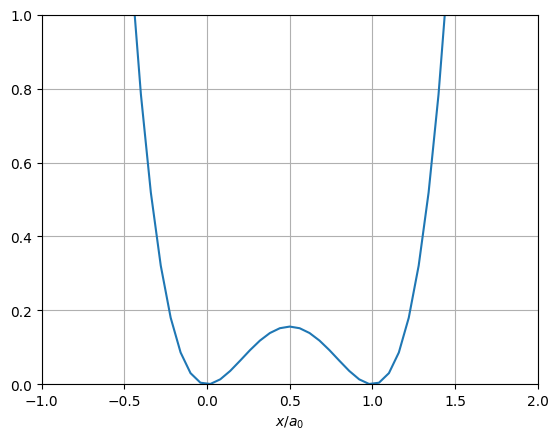

<Figure size 640x480 with 0 Axes>

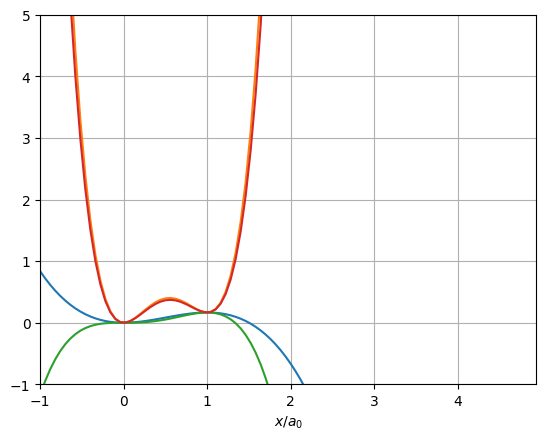

In [116]:
# Plot f and g functions
sys1 = cf.BaseSystem(1,xRes=100,xlim = (-1,5),ylim=(0,1))

f1 = 0.25*sys1.x**2*(sys1.x-1)**2
# f2 = sys1.x**4*(sys1.x-1)**4
g = 3*sys1.x**2-2*sys1.x**3
g_2 = 4*sys1.x**3-3*sys1.x**4
f_g = 20*f1 +(1/6)*g
f_g_2 = 20*f1+(1/6)*g_2
# good shape only for alpha lower or equals to 0.2

sys1.plot_field(10*f1,xlim = (-1,2),ylim=(0,1), label = "f1")
plt.figure()
# sys1.plot_field(f2,xlim = (-1,2),ylim=(0,1), label = "f2")
plt.figure()
sys1.plot_field((1/6)*g, xlim = (-1,5),ylim=(-1,5), label = "g")
sys1.plot_field(f_g, label = "f_g")
# plt.figure()
sys1.plot_field((1/6)*g_2, xlim = (-1,5),ylim=(-1,5), label = "g")
sys1.plot_field(f_g_2, label = "f_g_2")
# plt.legend()

Thanks to the previous plot, we find a value for α that fits. We want that the final f functional (orange curve) has a lower minimum in 0 than in 1. This happens only for α<=0.2 . But the values for which the minimum are reached are not preserved --> problem to fix

In [122]:
# Make linear operator
def calc_omega_f(self):
    return -0.5*self.calc_k2() - (0.5*self.k1+6*self.a)

# Add method to class
LandauSystem.calc_omega_f = calc_omega_f

# Make the non-linear operator
def calc_nonlinear_evolution_function_f(self, field, t):
    N = -self.k1*field**3+2*self.k1*field**2+6*self.a*field**2
    return sp.fft.fftn(N)

# Add method to class
LandauSystem.calc_nonlinear_evolution_function_f = calc_nonlinear_evolution_function_f

In [123]:
def evolve(self, number_steps):
    omega_f = calc_omega_f(self)

    integrating_factors_f, solver = self.calc_integrating_factors_f_and_solver(omega_f, 'ETD2RK')

    for n in range(number_steps):
        self.psi, self.psi_f = solver(integrating_factors_f,
                                    self.calc_nonlinear_evolution_function_f,
                                    self.psi, self.psi_f)
        self.psi = np.real(self.psi)

# Add evolve method to class
LandauSystem.evolve = evolve

Initialisation with a psi field which is one everywhere (intact material) except in the middle --> see later how to adjust for scaling between 0 and 1

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

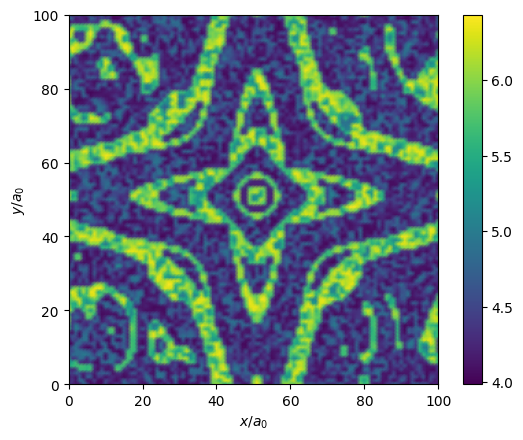

In [129]:
# Initiating a system with positive r value
# ls = LandauSystem(2,20,0.166)
ls = LandauSystem(2,1,1)

# Setting an initial condition with both positive and negative values
# ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Evolving the system
ls.evolve(200)
ls.plot_field(ls.psi)

Animation

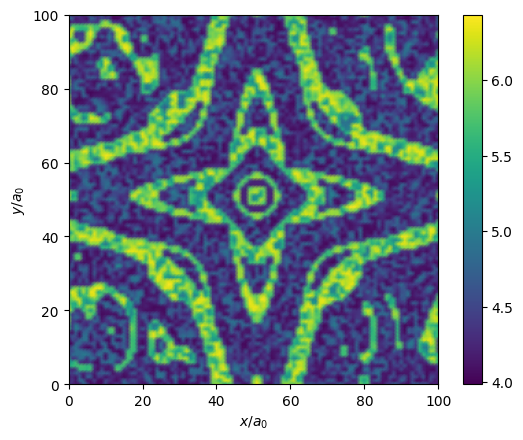

In [130]:
# Initiating a system with positive r value
ls = LandauSystem(2,1,1)

# Setting an initial condition with both positive and negative values
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(2)
    plt.clf() #Clearing current figure before plotting new one
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_1_1') #k=1 and a=1

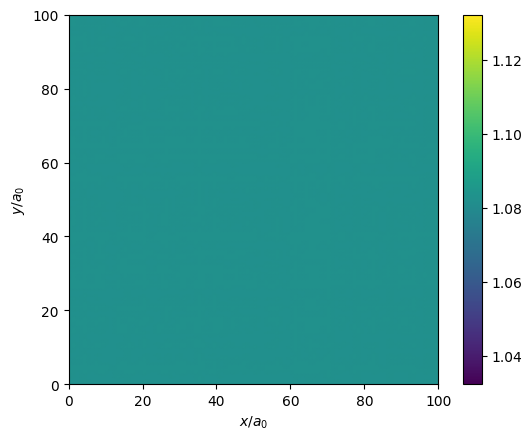

In [132]:
# Initiating a system with positive r value
ls = LandauSystem(2,1,-1)

# Setting an initial condition with both positive and negative values
ls.psi = np.ones((ls.xRes,ls.yRes))
ls.psi[51,51] = 0
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(2)
    plt.clf() #Clearing current figure before plotting new one
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_1_-1') #k=1 and a=1